In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip

# load pickle module
import pickle
import networkx as nx

In [2]:
def get_new_infections_position(infectors, total_new, num_fips):
    cum_inft = np.cumsum(infectors)
    cum_new_infections = np.cumsum(total_new)

    totoal_new_infection_l = np.zeros(int(np.sum(total_new)))
    num_inft_s_idx = 0
    inft_s_idx = 0
    for l_indx in range(num_fips):
        num_inft = infectors[l_indx]
        if num_inft > 0:
            num_inft_e_idx = num_inft_s_idx+num_inft
            infection_list_l = total_new[num_inft_s_idx:num_inft_e_idx]
            # the list of the number of infections caused by every infector
            num_ift_l = np.sum(infection_list_l)
            inft_e_idx = inft_s_idx + num_ift_l
            totoal_new_infection_l[int(inft_s_idx):int(inft_e_idx)] = l_indx
            # the position of infection in the list of all infections
            num_inft_s_idx = num_inft_e_idx
            inft_s_idx = inft_e_idx
    return totoal_new_infection_l

In [3]:
def superspreading_T_Loc_model(T, initials, nbi_para, pop, paras, WN, rand_seed):
    # initialise
    l0, i0 = initials
    r, p = nbi_para
    num_fips = len(pop)
    Z, Zb, D, Db = paras
    child_seeds = rand_seed.spawn(T)

    NewInf = np.zeros((num_fips, T))
    TotInf = np.zeros((num_fips, T))
    NewInf[l0, 0] = i0
    TotInf[:, 0] = NewInf[:, 0]

    for ti in range(T):
        infectors = np.int64(NewInf[:, ti])
        total_num_infectors = np.sum(infectors)
        pop_immu = 1-TotInf[:, ti]/pop[:]
        pop_immu[pop_immu < 0] = 0
        # create list of immu_prob * number of infectors
        immu_all = np.repeat(pop_immu, infectors)
        rng = np.random.default_rng(child_seeds[ti])
        tt = rng.negative_binomial(r, p, total_num_infectors)
        # to be assigned, every new infections for the infector
        total_new = np.round(tt*immu_all)
        totoal_new_infection_loc = get_new_infections_position(
            infectors, total_new, num_fips)

        z_num = np.int64(np.sum(total_new))
        NF = np.zeros((2, z_num), dtype=np.int64)
        # for the time distribution
        latency_p = SSA.gamma.rvs(a=Z, scale=Zb, size=z_num, random_state=rng)
        infectious_p = SSA.gamma.rvs(
            a=D, scale=Db, size=z_num, random_state=rng)
        v = rng.random(z_num)
        delay_days = latency_p+v*infectious_p  # 3+5*0.5

        NF[0, :] = np.ceil(delay_days+ti)  # make it idx int
        # for the location distribution
        NF[1, :] = totoal_new_infection_loc
        df = pd.DataFrame(NF.T, columns=['time', 'o_l'])
        l_list = np.arange(num_fips)
        df['d_l'] = df['o_l'].apply(
            lambda x: np.random.choice(l_list, size=1, p=WN[:, x])[0])
        df = df[df['time'] <= (T-1)]
        NF_ii = np.array(df)
        for (t, o, d) in NF_ii:
            NewInf[d, t] = NewInf[d, t]+1
        TotInf = np.cumsum(NewInf, axis=1)

    return NewInf, TotInf

In [75]:
WN = np.loadtxt('W_avg.csv')
pop = np.loadtxt('pop_new.csv')

In [7]:
N = len(pop)

In [61]:
### i want to illustrate that the network structure matters, 
## to compare with the current result, with the fixed seeding position, just look at the 
## if the superspreading is differentiable? is the phase?
g_r = nx.from_numpy_array(WN)
g_r.remove_edges_from(nx.selfloop_edges(g_r))
neighbours = list(g_r.neighbors(1858))
second_neighbours = []
for n in neighbours:
    s_n = list(g_r.neighbors(n))
    second_neighbours.extend(s_n)
second_neighbours = list(set(second_neighbours))
all_neighbours = neighbours + second_neighbours
position = list(set(all_neighbours))
g_r_sub = nx.subgraph(g_r,position)

In [172]:
### the mean value to stay in the same county rather than move out
print(np.mean(np.diag(WN)[position]) )
print(np.median(pop[position]))

0.8679736664701564
262966.0


In [63]:
num_edges_without_selfloops = g_r_sub.number_of_edges() - len(list(nx.selfloop_edges(g_r_sub)))

In [66]:
N_sub = g_r_sub.number_of_nodes()

In [68]:
avg_e = g_r_sub.number_of_edges()*2/N_sub
avg_e2 = num_edges_without_selfloops*2/N_sub
print('average degree,', avg_e)
print('average degree without selfloops,', avg_e2)

average degree, 9.758957654723128
average degree without selfloops, 9.758957654723128


In [93]:
p = avg_e2 / (N_sub - 1)
g_m = nx.erdos_renyi_graph(N_sub, p) ### there is no selfloops

In [152]:
A = nx.adjacency_matrix(g_m).toarray()

In [154]:
A_weighted = np.zeros((N_sub,N_sub))
for i in range(N_sub):
    out = np.float64(copy.deepcopy(A[:,i]))
    n_edges = np.sum(out==1) ###without selfloops no nodes are isolated
    out[out==1] = 1-0.868
    out_w = out/n_edges
#     print(out_w)
    out_w[i] = 0.868
    A_weighted[:,i] = out_w

In [163]:
g_m_w = nx.from_numpy_array(A_weighted)

In [160]:
g_m_w.remove_edges_from(nx.selfloop_edges(g_m_w))
pos = nx.circular_layout(g_m_w)
edge_weights = nx.get_edge_attributes(g_m_w, "weight")
edge_width = np.array(list(edge_weights.values()))*2

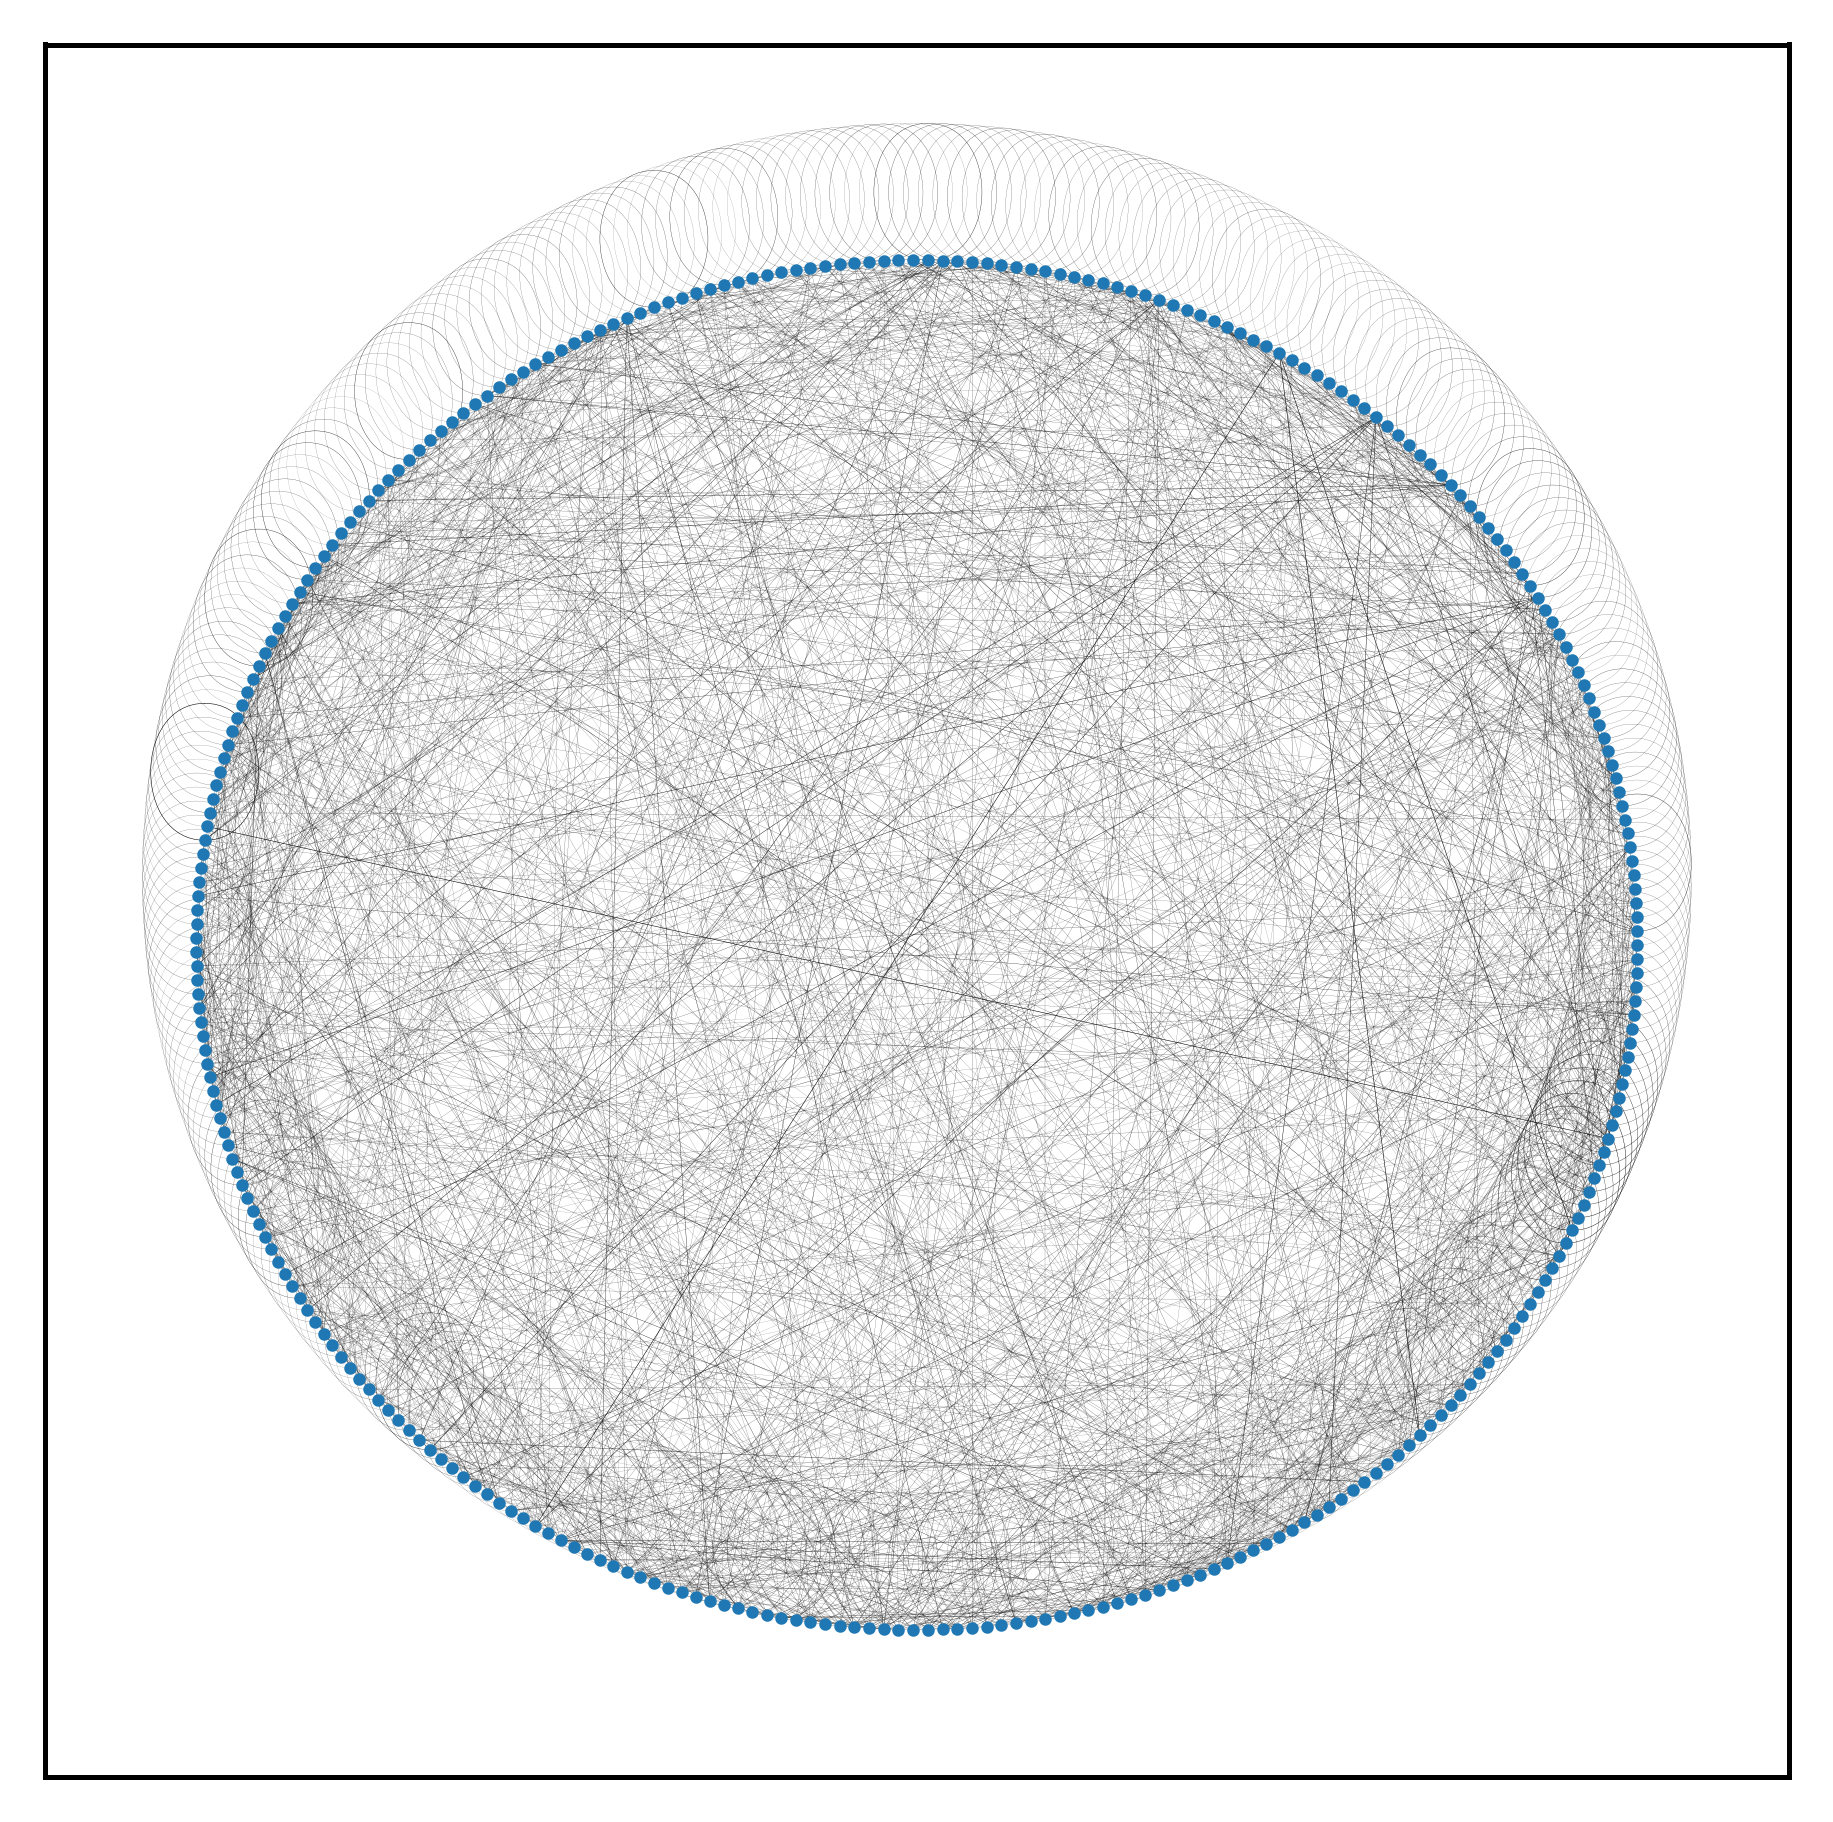

In [195]:
plt.figure(figsize=(5,5),dpi=450)
nx.draw_networkx(g_m_w,with_labels=False,node_size=1,pos=pos,width=edge_width)

In [244]:
ss = np.random.SeedSequence(0)
R0 = 2.5
# p = r/(R0+r)
Z = 3  # latent period
Zb = 1  # scale parameter for Z
D = 5  # infectious period
Db = 1  # scale parameter for b
T = 60
pop_sub = np.array([100000]*N_sub) #pop[position]
# pop_m = np.array([200000]*N_sub)

In [176]:
np.where(pop_sub==np.max(pop_sub))

(array([13]),)

In [220]:
rs = np.array([10., 2, 1, 0.5, 0.2, 0.1, 0.05, 0.025])
E_NewInf = np.zeros((8,100,N_sub,T))
for r_idx in range(8):
    r = rs[r_idx]
    print(r)
    p = r/(R0+r)
    for s in range(100):
        ss = np.random.SeedSequence(s)
        E_NewInf_i, E_TotInf_i = superspreading_T_Loc_model(T, (13, 50), (r, p), pop_sub, (Z, Zb, D, Db), A_weighted, ss)
        E_NewInf[r_idx,s,:,:] = E_NewInf_i

10.0
2.0
1.0
0.5
0.2
0.1
0.05
0.025


In [245]:
E_NewInf

(8, 100, 307, 60)

In [261]:
filename = 'E_NewInf_ER.txt'
with open(filename, "w") as file:
    for i in range(len(E_NewInf)):
        for j in range(len(E_NewInf[i])):
            for k in range(len(E_NewInf[i][j])):
                for l in range(len(E_NewInf[i][j][k])):
                    file.write(str(E_NewInf[i][j][k][l]))
                    file.write(" ")  # Separating the values by space
                file.write("\n")  # New line for every end of the 4th dimension

In [263]:
filename = "E_NewInf_ER.txt"

# Initialize an empty 4D list
reconstructed_4d_array = []

# Read the file and reconstruct the array
with open(filename, "r") as file:
    lines = file.readlines()

    # Assuming the structure of the saved 4D array is [a, b, c, d]
    a = 8  # Since our example was 2x2x2x2
    b = 100
    c = 307
    d = 60

    for i in range(a):
        a_list = []
        for j in range(b):
            b_list = []
            for k in range(c):
                line = lines[i*b*c + j*c + k].strip()  # get the appropriate line from lines
                c_list = [float(val) for val in line.split()]
                b_list.append(c_list)
            a_list.append(b_list)
        reconstructed_4d_array.append(a_list)


In [266]:
np.sum(reconstructed_4d_array == E_NewInf) == 8*100*307*60

True

In [259]:
newinf_pop = E_NewInf/pop_sub[None,None,:,None]*100000
temp = np.sum(newinf_pop>10,axis=2)
num_county = np.mean(temp,axis=1)
num_county_std = np.std(temp,axis=1)
# temp1
# num_county = np.sum(E_NewInf[:,:,:]>200,axis=1)
# E_NewInf

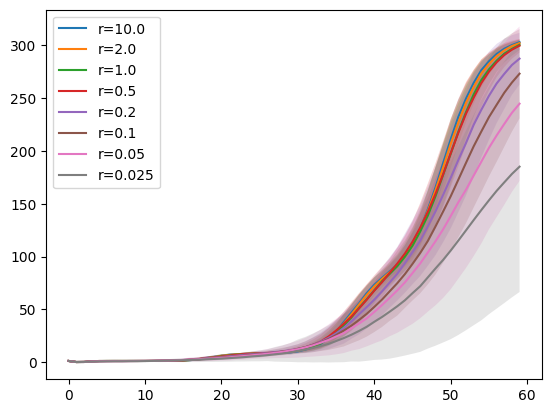

In [260]:
for r_idx in range(8):
    r = rs[r_idx]
    y = num_county[r_idx]
    y_e = num_county_std[r_idx]
    plt.plot(y,label='r={}'.format(r))
    plt.fill_between(range(60),y-y_e,y+y_e,alpha=0.2)
plt.legend()